In [15]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import torch
import matplotlib.pyplot as plt
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data import DataLoader
from albumentations.pytorch.transforms import ToTensorV2
from tqdm.notebook import tqdm
import albumentations as A

# from ipywidgets import IntProgress
import multiprocessing
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

from torchvision.ops import batched_nms
import mmcv

from ensemble_boxes import *

from matplotlib.pyplot import imshow
from PIL import Image

In [71]:
def plot_image(image, boxes, labels, scores):
    
    categories = [
        { 'id':0, 'name': 'Aortic enlargement'},
        { 'id':1, 'name': 'Atelectasis'},
        { 'id':2, 'name': 'Calcification'},
        { 'id':3, 'name': 'Cardiomegaly'},
        { 'id':4, 'name': 'Consolidation'},
        { 'id':5, 'name': 'ILD'},
        { 'id':6, 'name': 'Infiltration'},
        { 'id':7, 'name': 'Lung Opacity'},
        { 'id':8, 'name': 'Nodule/Mass'},
        { 'id':9, 'name': 'Other lesion'},
        { 'id':10, 'name': 'Pleural effusion'},
        { 'id':11, 'name': 'Pleural thickening'},
        { 'id':12, 'name': 'Pneumothorax'},
        { 'id':13, 'name': 'Pulmonary fibrosis'},
        { 'id':14, 'name': 'No finding'},
    ] 
    
    plt.figure(figsize=(10,10))
    
    for box,label, score in zip(boxes, labels, scores):
        cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (225,0,0), 1)
        label = categories[label]['name'].upper() + " " + str(score)
        print(label)
        cv2.putText(image, 
                    label,
                    (box[0], box[1]), 
                    fontFace = cv2.FONT_HERSHEY_COMPLEX, 
                    fontScale = 0.5,
                    color = (255, 0, 0),
                    thickness = 1,
                    lineType = cv2.LINE_AA
                   )
    plt.imshow(image)

In [76]:
df = pd.read_csv('10_fold_abnormal.csv')

meta = pd.read_csv('train_meta.csv').set_index('image_id')
fold_id = 0
train_df = df[df.fold_id != fold_id].groupby('image_id').agg(lambda x: list(x)).reset_index()
valid_df = df[df.fold_id == fold_id].groupby('image_id').agg(lambda x: list(x)).reset_index()


In [75]:
# def generate_data_json(df, output_file):

#     categories = [
#         { 'id':0, 'name': 'Aortic enlargement'},
#         { 'id':1, 'name': 'Atelectasis'},
#         { 'id':2, 'name': 'Calcification'},
#         { 'id':3, 'name': 'Cardiomegaly'},
#         { 'id':4, 'name': 'Consolidation'},
#         { 'id':5, 'name': 'ILD'},
#         { 'id':6, 'name': 'Infiltration'},
#         { 'id':7, 'name': 'Lung Opacity'},
#         { 'id':8, 'name': 'Nodule/Mass'},
#         { 'id':9, 'name': 'Other lesion'},
#         { 'id':10, 'name': 'Pleural effusion'},
#         { 'id':11, 'name': 'Pleural thickening'},
#         { 'id':12, 'name': 'Pneumothorax'},
#         { 'id':13, 'name': 'Pulmonary fibrosis'},
#     ] 

#     n = len(df)

#     annotations = []
    
#     df_annotations = []
#     images = []
    
#     obj_count = 0

#     for idx in tqdm(range(n)):

#         records = df.loc[idx]
#         image_id = records['image_id']

#         width = meta.loc[image_id]['dim1'] // 2
#         height = meta.loc[image_id]['dim0'] // 2
    
#         images.append(dict(
#             id=idx,
#             file_name=image_id + '.jpg',
#             height=height,
#             width=width))
 
#         boxes = records[['x_min','y_min', 'x_max', 'y_max']].to_numpy()
#         boxes = np.array(boxes.tolist()).T
        
#         boxes[:, 0] = boxes[:, 0] / width
#         boxes[:, 2] = boxes[:, 2] / width
#         boxes[:, 1] = boxes[:, 1] / height
#         boxes[:, 3] = boxes[:, 3] / height
        
#         labels = records['class_id']

#         scores = np.ones(len(labels))
                
# #         filtering dublicates from multiple radiologists 
#         boxes, scores, labels = weighted_boxes_fusion([boxes], [scores], [labels], iou_thr=0.4)

#         boxes[:, 0] = boxes[:, 0] * width
#         boxes[:, 2] = boxes[:, 2] * width
#         boxes[:, 1] = boxes[:, 1] * height
#         boxes[:, 3] = boxes[:, 3] * height
        
#         boxes = boxes.astype(int)
        
#         labels = labels.astype(int)
        
# #         plot_image(image, boxes, labels, scores)
        
#         for i in range(len(boxes)):

#             label = labels[i]

#             bbox = boxes[i]
#             area = (bbox[2] - bbox[0]) * (bbox[3] - bbox[1])
            
#             data_anno = dict(
#                 image_id=idx,
#                 id=obj_count,
#                 category_id=label,
#                 bbox=[bbox[0], bbox[1], bbox[2] - bbox[0], bbox[3] - bbox[1]],
#                 area=area,
#                 iscrowd=0)
            
#             annotations.append(data_anno)
            
#             box_anno = dict(
#                 image_id=image_id,
#                 class_id=label,
#                 x_min=bbox[0],
#                 y_min=bbox[1],
#                 x_max=bbox[2],
#                 y_max=bbox[3],
#                 area=area,
#                 width=width,
#                 height=height)

#             df_annotations.append(box_anno)
            
#             obj_count += 1
    
#     d = pd.DataFrame(df_annotations)
#     d.to_csv('dedub_abnormal.csv', index=False)
            
# #     coco_format_json = dict(
# #         images=images,
# #         annotations=annotations,
# #         categories=categories)
# #     mmcv.dump(coco_format_json, output_file)
# generate_data_json(df, 'fold_0_abnormal_train_coco_org.json')

In [80]:
def generate_data_json(df, output_file):

    categories = [
        { 'id':0, 'name': 'Aortic enlargement'},
        { 'id':1, 'name': 'Atelectasis'},
        { 'id':2, 'name': 'Calcification'},
        { 'id':3, 'name': 'Cardiomegaly'},
        { 'id':4, 'name': 'Consolidation'},
        { 'id':5, 'name': 'ILD'},
        { 'id':6, 'name': 'Infiltration'},
        { 'id':7, 'name': 'Lung Opacity'},
        { 'id':8, 'name': 'Nodule/Mass'},
        { 'id':9, 'name': 'Other lesion'},
        { 'id':10, 'name': 'Pleural effusion'},
        { 'id':11, 'name': 'Pleural thickening'},
        { 'id':12, 'name': 'Pneumothorax'},
        { 'id':13, 'name': 'Pulmonary fibrosis'},
    ] 

    n = len(df)

    annotations = []
    images = []
    
    obj_count = 0

    for idx in tqdm(range(n)):

        records = df.loc[idx]
        image_id = records['image_id']
        
        width = meta.loc[image_id]['dim1'] // 2
        height = meta.loc[image_id]['dim0'] // 2
    
        images.append(dict(
            id=idx,
            file_name=image_id + '.jpg',
            height=height,
            width=width))
 
        boxes = records[['x_min','y_min', 'x_max', 'y_max']].to_numpy()
        boxes = np.array(boxes.tolist()).T
        
        labels = records['class_id']
          
        for i in range(len(boxes)):

            label = labels[i]

            bbox = boxes[i]
            area = (bbox[2] - bbox[0]) * (bbox[3] - bbox[1])
            
            data_anno = dict(
                image_id=idx,
                id=obj_count,
                category_id=label,
                bbox=[bbox[0], bbox[1], bbox[2] - bbox[0], bbox[3] - bbox[1]],
                area=area,
                iscrowd=0)
            
            annotations.append(data_anno)
            
            obj_count += 1
    
    coco_format_json = dict(
        images=images,
        annotations=annotations,
        categories=categories)
    mmcv.dump(coco_format_json, output_file)

In [81]:
generate_data_json(train_df, 'fold_0_abnormal_train_coco_org.json')

  0%|          | 0/3946 [00:00<?, ?it/s]

In [82]:
generate_data_json(valid_df, 'fold_0_abnormal_valid_coco_org.json')

  0%|          | 0/448 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PULMONARY FIBROSIS 1.0
CARDIOMEGALY 1.0
AORTIC ENLARGEMENT 1.0
INFILTRATION 1.0
PLEURAL THICKENING 1.0
PLEURAL THICKENING 1.0
PLEURAL EFFUSION 1.0
PLEURAL EFFUSION 1.0


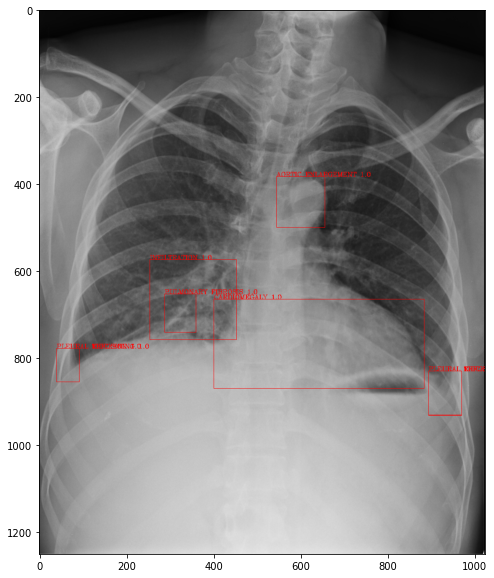

In [85]:
df = pd.read_csv('10_fold_abnormal.csv').groupby('image_id').agg(lambda x: list(x)).reset_index()

idx = 1000
records = df.loc[idx]
image_id = records['image_id']

img_path = 'train_2x/train/' + image_id + '.jpg'

image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = image / 255
image = image.astype('float32')

width = meta.loc[image_id]['dim1']
height = meta.loc[image_id]['dim0']

boxes = records[['x_min','y_min', 'x_max', 'y_max']].to_numpy()
boxes = np.array(boxes.tolist()).T
labels = records['class_id']
scores = np.ones(len(labels))

plot_image(image, boxes, labels, scores)

In [83]:
test_df = pd.read_csv('test.csv')
categories = [
    { 'id':0, 'name': 'Aortic enlargement'},
    { 'id':1, 'name': 'Atelectasis'},
    { 'id':2, 'name': 'Calcification'},
    { 'id':3, 'name': 'Cardiomegaly'},
    { 'id':4, 'name': 'Consolidation'},
    { 'id':5, 'name': 'ILD'},
    { 'id':6, 'name': 'Infiltration'},
    { 'id':7, 'name': 'Lung Opacity'},
    { 'id':8, 'name': 'Nodule/Mass'},
    { 'id':9, 'name': 'Other lesion'},
    { 'id':10, 'name': 'Pleural effusion'},
    { 'id':11, 'name': 'Pleural thickening'},
    { 'id':12, 'name': 'Pneumothorax'},
    { 'id':13, 'name': 'Pulmonary fibrosis'},
] 
images = []
for i in range(len(test_df)):
    r = test_df.iloc[i]
    image_id = r['image_id']
    images.append(dict(
        id=i,
        file_name=image_id + '.png',
        height=r['height'] // 2,
        width=r['width'] // 2))
coco_format_json = dict(
    images=images,
    categories=categories)
mmcv.dump(coco_format_json, 'test_coco_org.json')

In [712]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [714]:
%tensorboard --logdir checkpoints_resnext_512_16_epochs/tf_logs/

Reusing TensorBoard on port 6006 (pid 28701), started 0:03:48 ago. (Use '!kill 28701' to kill it.)